# Numerical Precision

In this section, you will investigate how different convolution
and matrix-matrix multiplication kernel performs when changing the
numerical precision.

## 1. Set-up

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a4-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
Cloning into 'a4-kpan02'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 45 (delta 13), reused 5 (delta 5), pack-reused 12 (from 1)
Receiving objects: 100% (45/45), 3.56 MiB | 2.24 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/gdrive/MyDrive/ece5545/a4-kpan02
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

Verify the following cell prints your github repository.

In [5]:
!ls {PROJECT_ROOT}

1-numerical_precision.ipynb  data      README.md  tests
2-svd_rank.ipynb	     mnist.py  src


In [6]:
!pip install torch numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

# 2. Convolution

In the following cell(s), please plot the reconstruction error of an
approximated tensor (in the y-axis) with the numerical precision
(in the x-axis). Please show one plot for `winograd` and one plot for `fft`.

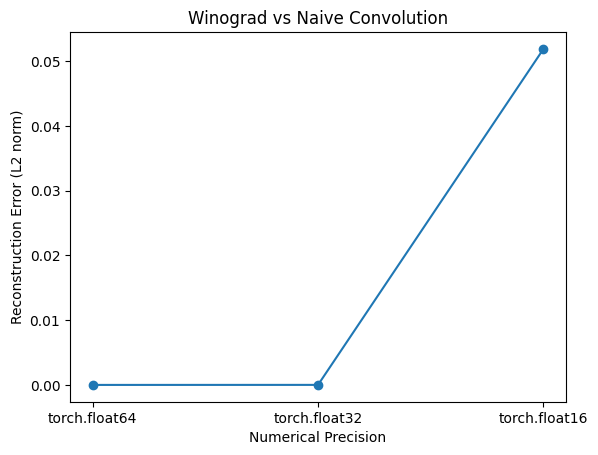

In [9]:
from src.conv2d import winograd, naive
# TODO: plot the error v.s. precision curve
import torch
import numpy as np
import matplotlib.pyplot as plt

H, W = 16, 16
Hk, Wk = 3, 3
x_np = np.random.randn(H, W)
k_np = np.random.randn(Hk, Wk)
b_np = np.random.randn(1)

precisions = [torch.float64, torch.float32, torch.float16]
errors = []

for dtype in precisions:
    x = torch.tensor(x_np, dtype=dtype)
    k = torch.tensor(k_np, dtype=dtype)
    b = torch.tensor(b_np, dtype=dtype)

    out_naive = naive(x, k, b).to(torch.float64)
    out_winograd = winograd(x, k, b).to(torch.float64)

    error = torch.norm(out_naive - out_winograd).item()
    errors.append(error)

plt.figure()
plt.plot([str(p) for p in precisions], errors, marker='o')
plt.xlabel('Numerical Precision')
plt.ylabel('Reconstruction Error (L2 norm)')
plt.title('Winograd vs Naive Convolution')
plt.show()

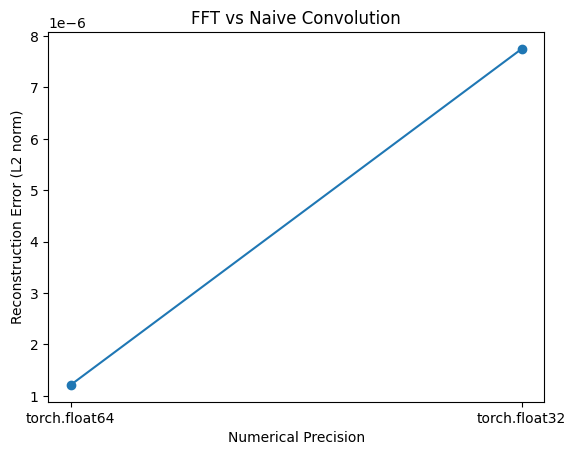

In [11]:
# TODO: plot the error v.s. precision curve
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.conv2d import fft, naive

H, W = 16, 16
Hk, Wk = 3, 3
x_np = np.random.randn(H, W)
k_np = np.random.randn(Hk, Wk)
b_np = np.random.randn(1)

precisions = [torch.float64, torch.float32]
errors = []

for dtype in precisions:
    x = torch.tensor(x_np, dtype=dtype)
    k = torch.tensor(k_np, dtype=dtype)
    b = torch.tensor(b_np, dtype=dtype)

    out_naive = naive(x, k, b).to(torch.float64)
    out_fft = fft(x, k, b).to(torch.float64)

    error = torch.norm(out_naive - out_fft).item()
    errors.append(error)

plt.figure()
plt.plot([str(p) for p in precisions], errors, marker='o')
plt.xlabel('Numerical Precision')
plt.ylabel('Reconstruction Error (L2 norm)')
plt.title('FFT vs Naive Convolution')
plt.show()

# 3. Matrix-matrix Multiply

In the following cell(s), please plot the reconstruction error (in the y-axis)
with the different numerical precisions (in the x-axis) for `log` (i.e.
logorithmic matrix-matrix multiplication).

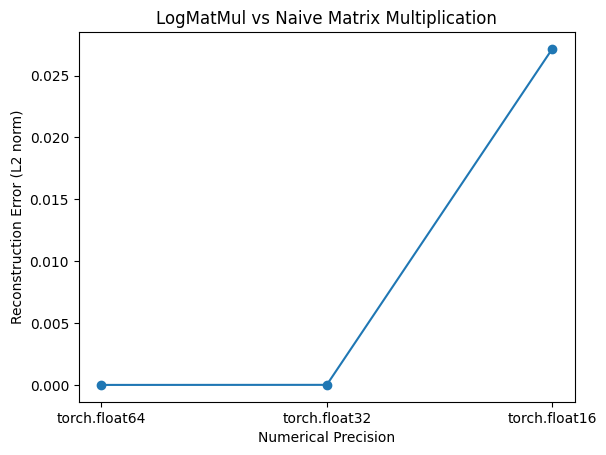

In [12]:
from src.matmul import logmatmul

# TODO: plot the error v.s. precision curve
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.matmul import logmatmul, naive

# Example input
N, M, K = 16, 16, 16
A_np = np.random.randn(N, M)
B_np = np.random.randn(M, K)

precisions = [torch.float64, torch.float32, torch.float16]
errors = []

for dtype in precisions:
    try:
        A = torch.tensor(A_np, dtype=dtype)
        B = torch.tensor(B_np, dtype=dtype)
        out_naive = naive(A, B).to(torch.float64)
        out_log = logmatmul(A, B).to(torch.float64)
        error = torch.norm(out_naive - out_log).item()
    except Exception as e:
        print(f"Skipping {dtype}: {e}")
        error = np.nan
    errors.append(error)

plt.figure()
plt.plot([str(p) for p in precisions], errors, marker='o')
plt.xlabel('Numerical Precision')
plt.ylabel('Reconstruction Error (L2 norm)')
plt.title('LogMatMul vs Naive Matrix Multiplication')
plt.show()
